# First protocol
_Code written and runs in python 3.11.0. Modify environment variables and queries as needed._  
_Please use venv_

## Protocol
· Start with keywords:

- Smartchain

- Nft

- Airdrop

- Crypto

- …etc.

1. Sample up to 10k tweets containing at least one term from 100 random hours from the past year (so 1M tweets)

2. Determine the most engaged (top) with users from this combined sample (100 or 1000)

3. Pull up to 1000 comments for each top user

4. Determine top users whose comments mention at least three users other than the top user

5. Expand top user sample if we don’t have at least 100 airdrop seeders

6. Time series chart plots:

7. Top user activity

8. Airdrop seeder activity

9. Negative reaction activity? (based on sentiment analysis of replies to airdrop messages)

10. External crypto value signals (from where?)



# Dependencies
Run the following commands in the terminal to install the required packages

$pip install requests  
  
$pip install pandas  
  
$pip install datetime  
  
$pip install python-dateutil
  

--------------------  

Crypto packages/api's:
https://medium.com/codex/10-best-resources-to-fetch-cryptocurrency-data-in-python-8400cf0d0136

https://www.alphavantage.co/documentation/


Financial tools/packages:
https://twitter.com/pyquantnews/status/1568029967052640256?t=EthvrNWmYhAFDVOhRoDxrQ&s=03

https://pmorissette.github.io/ffn/quick.html#data-retrieval


# Authentication step
In the code cell below replace bearer_token with your bearer token. Run the cell, then delete your bearer token.
This creates the token as an environment variable to be used under the name TOKEN. The token can then be removed so that others do not have access to your token when code is shared via GitHub. I will change this to dotenv and a .gitignore file later I just havent done that yet.

In [2]:
import os
os.environ['TOKEN'] = ''

In [23]:
import json
import pandas as pd
import csv
from typing import Optional
import time
import datetime
import random
import requests
from statistics import mean

"""This code creates functions to be used for authentication as well as creating endpoints."""
def auth():
    """Retrieves your bearer token."""
    return os.getenv('TOKEN')

def create_headers(bearer_token):
    """Creates headers for proper authentication from an API request."""
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers


def create_full_search_url(keyword: str, start_date: str, end_date: str, max_results: int = 100):
    """Creates queries and params for a full archive search url."""
    search_url: str = "https://api.twitter.com/2/tweets/search/all" 

    # change params to desired params
    query_params: dict = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'referenced_tweets.id.author_id',
                    'tweet.fields': 'id,author_id,conversation_id,created_at,in_reply_to_user_id,lang,public_metrics,referenced_tweets,source,text',
                    #'user.fields': 'id,name,public_metrics,username,verified',
                    #'place.fields': 'country',
                    'next_token': {}}
    return (search_url, query_params)

def get_author_id_from_tweet_id(tweet_id: str):
    """Creates queries to find the author id of a tweet's author."""
    search_url: str = f"https://api.twitter.com/2/tweets/{tweet_id}" 

    # change params to desired params
    query_params: dict = {'tweet.fields': 'author_id'}
    b_tok = auth()
    headers = create_headers(b_tok)
    response = requests.request("GET", search_url, headers = headers, params = query_params)
    print(response.status_code)
    json_response = response.json()
    if 'data' in json_response:
        return(response.json()['data']['author_id'])

def connect_to_endpoint(url, headers, params, next_token = None):
    """This takes a url from a url creation function and the params from the same function as well as an optional next token and returns a json object response from the endpoint."""
    params['next_token'] = next_token   # if a next token is found this will assign it to params 'next_token' key
    response = requests.request("GET", url, headers = headers, params = params)
    print("\nEndpoint Response Code: " + str(response.status_code)) # prints the enpoint response code for debugging help
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()


"""This code cell contains two functions (is_leap_year and random_date) which help generate a random one hour date range when random_date() is called"""
def is_leap_year(year: int):
    """Returns True if the given year in typical four digit year format (i.e. 2023) is a leap year, False otherwise."""
    if year % 4 == 0:
        if year % 100 == 0:
            if year % 400 == 0:
                return True
            else:
                return False
        else:
            return True
    else:
        return False

def sort_timestamps(timestamps: list):
    """This function takes the list of start and end times in rfc 3339 format, returned from the return_n_random_hour_ranges_sorted function, and sorts the lists in chronological order."""
    # Convert timestamps to datetime objects
    datetimes = [datetime.datetime.fromisoformat(ts) for ts in timestamps]
    # Sort datetime objects
    datetimes.sort()
    # Convert sorted datetime objects back to timestamps
    sorted_timestamps = [dt.strftime("%Y-%m-%dT%H:%M:%SZ") for dt in datetimes]
    return sorted_timestamps

def random_date():
    """Generate a random one hour date range within the last year in RFC 3339 format to be used with twitter API."""
    month = random.randint(1, 12)
    year = random.randint(datetime.datetime.now().year - 1, datetime.datetime.now().year)
    if month <= datetime.datetime.now().month:
        year = datetime.datetime.now().year
    else:
        year = datetime.datetime.now().year - 1
    if month == datetime.datetime.now().month:
        if datetime.datetime.now().day <= 2:
            day = 1
        else:
            day = random.randint(1, datetime.datetime.now().day - 1)
    elif month == 2:
        if is_leap_year(year):
            day = random.randint(1, 29)
        else:
            day = random.randint(1, 28)
    elif month in [1, 3, 5, 7, 8, 10, 12]:
        day = random.randint(1, 31)
    else:
        day = random.randint(1, 30)
    hour = random.randint(0, 23)
    start_time = datetime.datetime(year, month, day, hour)
    end_time = start_time + datetime.timedelta(hours=1)
    start_timestamp = start_time.strftime("%Y-%m-%dT%H:%M:%SZ")
    end_timestamp = end_time.strftime("%Y-%m-%dT%H:%M:%SZ")
    return start_timestamp, end_timestamp

def list_of_one_day_ranges_for_rfc_3339_past_year():
    """Generates 365 one day ranges in rfc3339 format starting at the specified date."""
    start_time_list: list = list()
    end_time_list: list = list()
    time1 = datetime.datetime.now()
    time1 = time1.replace(hour=0, minute=0, second=0, microsecond=0)
    time1 = time1 - datetime.timedelta(days=365)
    #time1 = datetime.datetime(2022, 3, 1, 0)
    time1 = time1.strftime("%Y-%m-%dT%H:%M:%SZ")
    for i in range(365):
        start_time_list.append(time1)
        time2 = add_day_to_timestamp(time1)
        end_time_list.append(time2)
        time1 = add_day_to_timestamp(time1)
        
    return start_time_list, end_time_list
        
def list_of_one_day_ranges_for_rfc_3339_since_specific_date():
    """Generates 365 one day ranges in rfc3339 format starting at the specified date."""
    start_time_list: list = list()
    end_time_list: list = list()
    time1 = datetime.datetime(2023, 2, 1)
    time1 = time1.replace(hour=0, minute=0, second=0, microsecond=0)
    time1 = time1 - datetime.timedelta(days=365)
    #time1 = datetime.datetime(2022, 3, 1, 0)
    time1 = time1.strftime("%Y-%m-%dT%H:%M:%SZ")
    for i in range(365):
        start_time_list.append(time1)
        time2 = add_day_to_timestamp(time1)
        end_time_list.append(time2)
        time1 = add_day_to_timestamp(time1)

    return start_time_list, end_time_list

def return_n_random_hour_ranges_sorted(n: int) -> list:
    """This returns two SORTED lists of start times and end times (where each index of the end time is one hour after the same index in start time)."""
    """This function returns n number of one hour ranges."""
    start_time1_list: list = list()
    end_time1_list: list = list()
    for i in range(0, n):
        s1, s2 = random_date()
        while s1 in start_time1_list:
            s1, s2 = random_date()
        start_time1_list.append(s1)
        end_time1_list.append(s2)

    sorted_start = sort_timestamps(start_time1_list)
    sorted_end = sort_timestamps(end_time1_list)
    return (sorted_start, sorted_end)


def tweets_per_range(keyword: str, start_times_list: list, end_times_list: list, results_per_range: int, next_token: Optional[str] = None) -> None:
    """This function takes a keyword(s), a list of start times and end times, and a integer amount of results per range."""
    """It then creates json files for each time range and stores the tweet results in those json files."""
    
    # AUTHENTICATION
    bearer_token = auth()
    headers: dict[str, str] = create_headers(bearer_token)
    # AUTHENTICATION

    json_obj_by_time_range: dict[str, dict] = dict() # creates a dictionary to which the time range will be created as a key and can therefore be found while in the json file
    max_results: int = 500 # this is the max results per request the twitter API allows and should be left at 500
    total_tweets_for_func_call: int = 0

    # Loops through the time ranges in a list
    for i in range(0, len(start_times_list)):
        json_obj_by_time_range: dict[str, dict] = dict()
        print("top of FOR loop")
        total_count = 0 # Tracks
        
        # Creates url and connects to endpoint then assignts the json object API response to json_obj_response
        url = create_full_search_url(keyword, start_times_list[i], end_times_list[i], max_results)
        json_obj_response = connect_to_endpoint(url[0], headers, url[1], next_token) # prints response code
        print(f"Outer for loop enpoint called for list index {i} / {len(start_times_list) - 1}") # for quality control
        json_obj_response.pop('includes', None) # removes 'includes' key which is a negative externality of calling 'referenced_tweets.id.author_id' expansion
        json_obj_response['time'] = [start_times_list[i], end_times_list[i]] # adds a 'time' key to the json_obj_response so that the time range of all tweets can be found by calling json_object_response['time']

        # Appends the json object API response to the json_obj_by_time_range dictionary
        json_obj_by_time_range[f'time_range_{i}'] = json_obj_response
        total_count += json_obj_response['meta']['result_count'] # increases the total count counter by the results count in the first API 'GET'
        print(f"endpoint called and data collected: {total_count} / {results_per_range} tweets in this range scraped")
        time.sleep(5) # time.sleep implementations are seen throughout the code to avoid hitting rate limits of twitter API
        
        # If there were insifficient results from first 'GET' request to meet the results per range value then the API begins to paginate to scrape more resutls
        while total_count <= results_per_range: 
            # Checks for next token in json response
            print("top of WHILE loop")
            if 'next_token' in json_obj_response['meta']: 
                
                next_token: str = json_obj_response['meta']['next_token'] # assigns 'next_token' to next_token: str object for easy use

                # Creates url and connects to endpoint then assignts the JSON API response to json_obj_esponse
                json_obj_response = connect_to_endpoint(url[0], headers, url[1], next_token) # prints response code
                print(f"While loop enpoint called: index {i} / {len(start_times_list) - 1}") # for quality control
                
                next_token = None # ensures next token does not get passed into another function call 

                if 'data' in json_obj_response:
                    # Loops through dictionaries in json_obj_response and appends them to the main json file
                    # This is done because while theoretically the entire item count be appended at once, certain python vectorizing methods might cause disagreeable types. Looping through items avoids this happening
                    for item in json_obj_response['data']:
                        json_obj_by_time_range[f'time_range_{i}']['data'].append(item)
                    
                    total_count += json_obj_response['meta']['result_count'] # increments the result count to match the total results currently aquired
                    json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] = total_count # changes the result count 'key' to meet the result count of all data

                    if json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] > results_per_range:
                        del json_obj_by_time_range[f'time_range_{i}']['data'][results_per_range:]
                        json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] = len(json_obj_by_time_range[f'time_range_{i}']['data'])

                    print(f"data key found and data appended: {total_count} / {results_per_range} tweets in this range scraped") # quality control
                    print(f"list index {i} / {(len(start_times_list) - 1)}")

                else:
                    print("empty next token") # quality control
                    print(f"max results scraped: {total_count} / {results_per_range} tweets in this range scraped") # quality control
                    print(f"list index {i} / {(len(start_times_list) - 1)} scraping over. Total tweets will be less than desired")
                    break
            
            else:
                print("No more tweets to scrape, total tweets will be less than amount desired.") # quality control
                print(f"total results {total_count}") # quality control
                next_token = None # ensures next token does not get passed into another function call
                break # exits while loop and calls for the next time range or terminates entire process
            

            time.sleep(5) # for rate limit 
        total_tweets_for_func_call += len(json_obj_by_time_range[f'time_range_{i}']['data'])
        print(f"{total_tweets_for_func_call} tweets scraped in entire function call")
        time.sleep(5) # for rate limit

            
        json_to_file = json.dumps(json_obj_by_time_range) # converts results from above code to a serialized json obj
        # Creates json file in directory of program and writes serialized json obj to the newly made file
        with open(f"data_range_{i}.json", "w") as outfile:
            outfile.write(json_to_file)

def tweets_per_range_replies_to_user(user: str, start_times_list: list, end_times_list: list, results_per_range: int, next_token: Optional[str] = None) -> None:
    """This function takes a keyword(s), a list of start times and end times, and a integer amount of results per range."""
    """It then creates json files for each time range and stores the tweet results in those json files."""
    
    # AUTHENTICATION
    bearer_token = auth()
    headers: dict[str, str] = create_headers(bearer_token)
    # AUTHENTICATION

    json_obj_by_time_range: dict[str, dict] = dict() # creates a dictionary to which the time range will be created as a key and can therefore be found while in the json file
    max_results: int = 500 # this is the max results per request the twitter API allows and should be left at 500
    total_tweets_for_func_call: int = 0

    # Loops through the time ranges in a list
    for i in range(0, len(start_times_list)):
        json_obj_by_time_range: dict[str, dict] = dict()
        print("top of FOR loop")
        total_count = 0 # Tracks
        
        # Creates url and connects to endpoint then assignts the json object API response to json_obj_response
        url = create_full_search_url(keyword, start_times_list[i], end_times_list[i], max_results)
        json_obj_response = connect_to_endpoint(url[0], headers, url[1], next_token) # prints response code
        print(f"Outer for loop enpoint called for list index {i} / {len(start_times_list) - 1}") # for quality control
        json_obj_response.pop('includes', None) # removes 'includes' key which is a negative externality of calling 'referenced_tweets.id.author_id' expansion
        json_obj_response['time'] = [start_times_list[i], end_times_list[i]] # adds a 'time' key to the json_obj_response so that the time range of all tweets can be found by calling json_object_response['time']

        # Appends the json object API response to the json_obj_by_time_range dictionary
        json_obj_by_time_range[f'time_range_{i}'] = json_obj_response
        total_count += json_obj_response['meta']['result_count'] # increases the total count counter by the results count in the first API 'GET'
        print(f"endpoint called and data collected: {total_count} / {results_per_range} tweets in this range scraped")
        time.sleep(5) # time.sleep implementations are seen throughout the code to avoid hitting rate limits of twitter API
        
        # If there were insifficient results from first 'GET' request to meet the results per range value then the API begins to paginate to scrape more resutls
        while total_count <= results_per_range: 
            # Checks for next token in json response
            print("top of WHILE loop")
            if 'next_token' in json_obj_response['meta']: 
                
                next_token: str = json_obj_response['meta']['next_token'] # assigns 'next_token' to next_token: str object for easy use

                # Creates url and connects to endpoint then assignts the JSON API response to json_obj_esponse
                json_obj_response = connect_to_endpoint(url[0], headers, url[1], next_token) # prints response code
                print(f"While loop enpoint called: index {i} / {len(start_times_list) - 1}") # for quality control
                
                next_token = None # ensures next token does not get passed into another function call 

                if 'data' in json_obj_response:
                    # Loops through dictionaries in json_obj_response and appends them to the main json file
                    # This is done because while theoretically the entire item count be appended at once, certain python vectorizing methods might cause disagreeable types. Looping through items avoids this happening
                    for item in json_obj_response['data']:
                        json_obj_by_time_range[f'time_range_{i}']['data'].append(item)
                    
                    total_count += json_obj_response['meta']['result_count'] # increments the result count to match the total results currently aquired
                    json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] = total_count # changes the result count 'key' to meet the result count of all data

                    if json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] > results_per_range:
                        del json_obj_by_time_range[f'time_range_{i}']['data'][results_per_range:]
                        json_obj_by_time_range[f'time_range_{i}']['meta']['result_count'] = len(json_obj_by_time_range[f'time_range_{i}']['data'])

                    print(f"data key found and data appended: {total_count} / {results_per_range} tweets in this range scraped") # quality control
                    print(f"list index {i} / {(len(start_times_list) - 1)}")

                else:
                    print("empty next token") # quality control
                    print(f"max results scraped: {total_count} / {results_per_range} tweets in this range scraped") # quality control
                    print(f"list index {i} / {(len(start_times_list) - 1)} scraping over. Total tweets will be less than desired")
                    break
            
            else:
                print("No more tweets to scrape, total tweets will be less than amount desired.") # quality control
                print(f"total results {total_count}") # quality control
                next_token = None # ensures next token does not get passed into another function call
                break # exits while loop and calls for the next time range or terminates entire process
            

            time.sleep(5) # for rate limit 
        total_tweets_for_func_call += len(json_obj_by_time_range[f'time_range_{i}']['data'])
        print(f"{total_tweets_for_func_call} tweets scraped in entire function call")
        time.sleep(5) # for rate limit

            
        json_to_file = json.dumps(json_obj_by_time_range) # converts results from above code to a serialized json obj
        # Creates json file in directory of program and writes serialized json obj to the newly made file
        with open(f"data_range_{i}.json", "w") as outfile:
            outfile.write(json_to_file)
        

"""This function takes all of the json files of tweet data and creates a sorted dictionary of the most appearing tweets."""
"""A post OR a retweet counts as ONE occurence of a tweet."""
def analyze_top_appearing_tweets_in_data(min_int_of_json: int, max_int_of_json: int, num_of_top_tweets: int) -> dict: # max_int_of_json is the max int of json files in your directory, this function will paginate through them
    tweet_metrics_dict: dict = dict()
    for i in range(0, max_int_of_json + 1):

        # opens json file and assigns serialized json data to data_file 
        f = open(f'data_range_{i}.json')
        data_file = json.load(f)

        for item in data_file[f'time_range_{i}']['data']: # loops through the tweets in json file and adds to a dict key of that tweet's id if the tweet appears
            temp_dict: dict = dict()
            # Increments each tweet id 'key' in tweet_metrics_dict by one for each appearance of a tweet or each retweet of that tweet
            if 'referenced_tweets' in item and item['referenced_tweets'][0]['type'] == "retweeted":
                original_tweet_id_from_retweet = item['referenced_tweets'][0]['id']
                if original_tweet_id_from_retweet in tweet_metrics_dict:
                    tweet_metrics_dict[original_tweet_id_from_retweet]['appearance_count'] += 1
            elif 'referenced_tweets' not in item:
                temp_dict['appearance_count'] = 1
                temp_dict['created_at'] = item['created_at']
                tweet_metrics_dict[original_tweet_id_from_retweet] = temp_dict
            else:
                continue

        f.close() # closes the json file

    #sorted_dict = {} # creates a dictionary to assist with sorting tweet id's by the most appearances
    #sorted_keys = sorted(tweet_metrics_dict, key=tweet_metrics_dict.get, reverse=True)  # sorts the keys by highes value (most tweet appearances)

    #for w in sorted_keys:
        #sorted_dict[w] = tweet_metrics_dict[w] # sorts the dictionary by value from greates to least
    # Sort the dictionary by the "total_appearances_in_dataset" value in descending order
    sorted_dict = dict(sorted(tweet_metrics_dict.items(), key=lambda x: x[1]['appearance_count'], reverse=True))
    final_dict = delete_after_num_in_dict(num_of_top_tweets, sorted_dict)
    return final_dict # returns sorted dict

def analyze_top_appearing_tweets_in_data_wrong_demo(max_int_of_json: int) -> dict: # max_int_of_json is the max int of json files in your directory, this function will paginate through them
    tweet_metrics_dict: dict = dict()
    for i in range(0, max_int_of_json + 1):

        # opens json file and assigns serialized json data to data_file 
        f = open(f'data_range_{i}.json')
        data_file = json.load(f)

        for item in data_file[f'time_range_{i}']['data']: # loops through the tweets in json file and adds to a dict key of that tweet's id if the tweet appears
            # Increments each tweet id 'key' in tweet_metrics_dict by one for each appearance of a tweet or each retweet of that tweet
            if 'referenced_tweets' in item and item['referenced_tweets'][0]['type'] == "retweeted":
                original_tweet_id_from_retweet = item['referenced_tweets'][0]['id']
                if original_tweet_id_from_retweet in tweet_metrics_dict:
                    tweet_metrics_dict[original_tweet_id_from_retweet] += 1
                else:
                    tweet_metrics_dict[original_tweet_id_from_retweet] = 1
            else:
                this_tweet_id = item['id']
                if this_tweet_id in tweet_metrics_dict:
                    tweet_metrics_dict[this_tweet_id] += 1
                else:
                    tweet_metrics_dict[this_tweet_id] = 1

        f.close() # closes the json file

    sorted_dict = {} # creates a dictionary to assist with sorting tweet id's by the most appearances
    sorted_keys = sorted(tweet_metrics_dict, key=tweet_metrics_dict.get, reverse=True)  # sorts the keys by highes value (most tweet appearances)

    for w in sorted_keys:
        sorted_dict[w] = tweet_metrics_dict[w] # sorts the dictionary by value from greates to least
    final = delete_after_num_in_dict(1100, sorted_dict)
    return final # returns sorted dict


def return_stats_of_file(num_of_file: int):
    f = open(f'data_range_{num_of_file}.json')
    data_file = json.load(f)
    print(f"There are {len(data_file[f'time_range_{num_of_file}']['data'])} tweets in this data file")
    print(data_file[f'time_range_{num_of_file}']['meta'])
    print(data_file[f'time_range_{num_of_file}']['time'])
    f.close()

def delete_after_num_in_dict(num: int, dictionary_obj: dict):
    count = 0
    empty_dict = dict()
    for item in dictionary_obj:
        count += 1
        if count > num:
            return empty_dict
        empty_dict[item] = dictionary_obj[item]

def analyze_top_retweeted_tweets_in_data(min_int_of_json: int, max_int_of_json: int, num_of_top_tweets: int) -> dict: # max_int_of_json is the max int of json files in your directory, this function will paginate through them
    tweet_metrics_dict: dict = dict()
    tweet_metrics_dict['data'] = list()
    for i in range(min_int_of_json, max_int_of_json + 1):

        # opens json file and assigns serialized json data to data_file 
        f = open(f'data_range_{i}.json')
        data_file = json.load(f)

        for item in data_file[f'time_range_{i}']['data']: # loops through the tweets in json file and adds retweet count to a dict key of that tweet's id 
            # Creates a key for each unique tweet id and assigns its retweet count to that key
            if 'referenced_tweets' in item and item['referenced_tweets'][0]['type'] == "retweeted":
                original_tweet_id_from_retweet = item['referenced_tweets'][0]['id']
                if original_tweet_id_from_retweet not in tweet_metrics_dict:
                    retweet_count = item['public_metrics']['retweet_count']
                    created_time = item['created_at']
                    tweet_metrics_dict[original_tweet_id_from_retweet] = [retweet_count, created_time]
            else:
                this_tweet_id = item['id']
                if this_tweet_id not in tweet_metrics_dict:
                    created_time = item['created_at']
                    tweet_metrics_dict[this_tweet_id] = [item['public_metrics']['retweet_count'], created_time]

        f.close() # closes the json file

    sorted_dict = {} # creates a dictionary to assist with sorting tweet id's by the most appearances
    sorted_keys = sorted(tweet_metrics_dict, key=tweet_metrics_dict.get, reverse=True)  # sorts the keys by highes value (most retweets)

    for w in sorted_keys:
        sorted_dict[w] = tweet_metrics_dict[w] # sorts the dictionary by value from greates to least
    final_dict = delete_after_num_in_dict(num_of_top_tweets, sorted_dict)
    
    #temp = len(final_dict)
    #count = 0
    #for item in final_dict:
        #print(f"{count} / {temp} item parsed")
        #count += 1
        #final_dict[item][1] = get_created_at_of_tweet_id(item)
    return final_dict # returns sorted dict


"""Gathers num_of_results number of replies to a tweet from conversation_id."""
def json_replies_to_tweet_from_conversation_id(conversation_id: str, num_of_results: int):

    # Make a request to the search endpoint to retrieve all tweets in the conversation
    bearer_token = auth()
    headers: dict[str, str] = create_headers(bearer_token)
    total_replies_scraped: int = 0

    response: requests.models.Response = requests.get(f"https://api.twitter.com/2/tweets/search/all?max_results=100&query=conversation_id:{conversation_id} is:reply&tweet.fields=author_id,in_reply_to_user_id,created_at,conversation_id", headers={"Authorization": f"Bearer {bearer_token}"})

    # Extract the tweets from the response
    reply_tweets: json = response.json()
    tweets_temp: json = reply_tweets
    total_replies_scraped = reply_tweets['meta']['result_count']

    # Checks if more replies need to be scraped and finds the next token if true"
    while total_replies_scraped < num_of_results:
        if 'next_token' in tweets_temp['meta']:
            next_token1: str = tweets_temp['meta']['next_token']
            response: requests.models.Response = requests.get(f"https://api.twitter.com/2/tweets/search/all?max_results=100&next_token={next_token1}&query=conversation_id:{conversation_id} is:reply&tweet.fields=author_id,in_reply_to_user_id,created_at,conversation_id", headers={"Authorization": f"Bearer {bearer_token}"})
            tweets_temp = response.json()
            if 'data' in tweets_temp:
                total_replies_scraped += tweets_temp['meta']['result_count']
                for item in tweets_temp['data']:
                    reply_tweets['data'].append(item)
                reply_tweets['meta']['result_count'] = total_replies_scraped
                if reply_tweets['meta']['result_count'] > num_of_results:
                    del reply_tweets['data'][num_of_results:]
                    reply_tweets['meta']['result_count'] = len(reply_tweets['data'])
            else:
                print("empty next token") # quality control
                print(f"max results scraped: {total_replies_scraped} / {num_of_results}") # quality control
                break
        else:
            print("No more tweets to scrape, total tweets will be less than amount desired.") # quality control
            print(f"total results {total_replies_scraped}") # quality control
            break
        time.sleep(5) # for rate limit 

        # Print the tweets
    print(f"tweet replies scraped/replies desired: {total_replies_scraped} / {num_of_results}") # quality control
    print(json.dumps(reply_tweets, indent=5))

def get_username_from_tweet_id(tweet_id: str):
    # Define the URL of the tweet endpoint
    tweet_url = f'https://api.twitter.com/2/users?ids={get_author_id_from_tweet_id(tweet_id)}'

    # Define your Twitter API credentials
    headers = {
        'Authorization': f'Bearer {auth()}',
        'User-Agent': 'YOUR_APP_NAME',
    }

    # Send a GET request to the URL
    response = requests.get(tweet_url, headers=headers)
    print(response.status_code)
    time.sleep(3.5)
    # Check if the request was successful
    if response.status_code == 200:
        # Load the response data into a Python dictionary
        tweet = json.loads(response.text)
        if 'data' in tweet:
            return(tweet['data'][0]['username'])
        else:
            return(f"")
    else:
        return(f"")

def collect_replies_to_user_from_username(username: str, start_time: str, end_time: str, num_replies: int):
    
    user_name: str = username
    max_rep = 100
    query = f'to%3A{user_name}'
    #query = 'to%3Adfreelon'
    #query = from%3Adfreelon
    tweet_fields = 'created_at,entities,public_metrics,id,text,lang'
    user_fields = 'created_at,description,entities,id,location,name,public_metrics,username,verified'
    #start_time = "2022-03-02T05:00:00Z"
    #end_time = "2022-03-06T14:00:00Z"
    expansions = 'referenced_tweets.id.author_id'

    headers1 = create_headers(auth())

    url = 'https://api.twitter.com/2/tweets/search/all?query=' + \
                    query + \
                    f'&max_results={max_rep}&start_time=' + \
                    start_time + \
                    '&end_time=' + \
                    end_time + \
                    '&tweet.fields=' + \
                    tweet_fields + \
                    '&expansions=' + \
                    expansions + \
                    '&user.fields=' + \
                    user_fields 

    # Creates url and connects to endpoint then assignts the json object API response to json_obj_response
    #reply_url = create_full_search_url('to%3Adfreelon', start_time, end_time, 100)
    response = requests.request("GET", url, headers = headers1)
    json_response = response.json()
    if 'meta' not in json_response:
        print(json_response)
        return json_response
    else:
        total_count = json_response['meta']['result_count']

    while total_count <= (num_replies - 50): 
            # Checks for next token in json response
            print("top of WHILE loop")
            
            if 'next_token' in json_response['meta']: 
                
                if (num_replies - total_count) < 500:
                    max_nums = (num_replies - total_count)
                else:
                    max_nums = 100
                next_token: str = json_response['meta']['next_token'] # assigns 'next_token' to next_token: str object for easy use
            
                url = 'https://api.twitter.com/2/tweets/search/all?query=' + \
                    query + \
                    f'&max_results={max_nums}&start_time=' + \
                    start_time + \
                    '&end_time=' + \
                    end_time + \
                    '&tweet.fields=' + \
                    tweet_fields + \
                    '&expansions=' + \
                    expansions + \
                    '&user.fields=' + \
                    user_fields + \
                    '&next_token=' + \
                    next_token

                # Creates url and connects to endpoint then assignts the JSON API response to json_obj_esponse
                response = requests.request("GET", url, headers = headers1) # prints response code
                json_response2 = response.json()
                #json_response['data'].append(json_response2)
                print(f"While loop enpoint called") # for quality control
                
                next_token = None # ensures next token does not get passed into another function call 

                if 'data' in json_response2:
                    # Loops through dictionaries in json_obj_response and appends them to the main json file
                    # This is done because while theoretically the entire item count be appended at once, certain python vectorizing methods might cause disagreeable types. Looping through items avoids this happening
                    for item in json_response2['data']:
                        json_response['data'].append(item)
                    if 'includes' in json_response2:
                        if 'users' in json_response2['includes']:
                            for item in json_response2['includes']['users']:
                                json_response['includes']['users'].append(item)
                        if 'tweets' in json_response2['includes']:
                            for item in json_response2['includes']['tweets']:
                                json_response['includes']['tweets'].append(item)
                        

                    total_count += json_response2['meta']['result_count'] # increments the result count to match the total results currently aquired
                    json_response['meta']['result_count'] = total_count # changes the result count 'key' to meet the result count of all data
                    if 'meta' in json_response2:
                        if 'next_token' in json_response2['meta']:
                            json_response['meta']['next_token'] = json_response2['meta']['next_token']
                    else:
                        json_response['meta']['next_token'] = None


                    if json_response['meta']['result_count'] > num_replies:
                        del json_response['data'][num_replies:]
                        json_response['meta']['result_count'] = len(json_response['data'])

                    print(f"data key found and data appended: {total_count} / {num_replies} tweets in this range scraped") # quality control
                    json_response2 = {}
                    
                else:
                    print("empty next token") # quality control
                    print(f"max results scraped: {total_count} / {num_replies} tweets in this range scraped") # quality control
                    print(f"Total tweets will be less than desired")
                    break
            
            else:
                print("No more tweets to scrape, total tweets will be less than amount desired.") # quality control
                print(f"total results {total_count}") # quality control
                next_token = None # ensures next token does not get passed into another function call
                break # exits while loop and calls for the next time range or terminates entire process
            

            time.sleep(5) # for rate limit 
    print(total_count)
    if 'data' in json_response:
        total_count = len(json_response['data'])
    print(f"{total_count} tweets scraped in entire function call")
    time.sleep(5) # for rate limit

    # converts results from above code to a serialized json obj
    return(json.dumps(json_response, indent=5))

def get_created_at_of_tweet_id(tweet_id: str):
    """Creates queries to find the author id of a tweet's author."""
    search_url: str = f"https://api.twitter.com/2/tweets/{tweet_id}" 

    # change params to desired params
    query_params: dict = {'tweet.fields': 'created_at'}
    b_tok = auth()
    headers = create_headers(b_tok)
    response = requests.request("GET", search_url, headers = headers, params = query_params)
    time.sleep(4)
    print("\nEndpoint Response Code: " + str(response.status_code)) # prints the enpoint response code for debugging help
    json_response = response.json()
    if 'data' in json_response:
        if 'created_at' in json_response['data']:
            return(json_response['data']['created_at'])
        else:
            return(tweet_id)
    else:
        return(tweet_id)
    
def add_week_to_timestamp(timestamp):
    # parse the input timestamp into a datetime object
    dt = datetime.datetime.fromisoformat(timestamp)

    # add one week to the datetime object
    dt = dt + datetime.timedelta(weeks=1)

    # return the resulting timestamp in the desired format
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

def add_day_to_timestamp(timestamp):
    # parse the input timestamp into a datetime object
    dt = datetime.datetime.fromisoformat(timestamp)

    # add one week to the datetime object
    dt = dt + datetime.timedelta(days=1)

    # return the resulting timestamp in the desired format
    return dt.strftime("%Y-%m-%dT%H:%M:%SZ")

def creates_json_file_of_replies_to_top_users(dict_from_analyze_top_retweeted: dict):
    json_replies_to_most_retweeted_users: json = dict()
    count = 1
    for item in dict_from_analyze_top_retweeted:
        print(f"{count} / {len(dict_from_analyze_top_retweeted)}")
        count += 1
        username_of_tweet = dict_from_analyze_top_retweeted[item][2]
        tweet_created_time = dict_from_analyze_top_retweeted[item][1]
        one_week_after_tweet_created = add_week_to_timestamp(tweet_created_time)
        response = collect_replies_to_user_from_username(username_of_tweet, tweet_created_time, one_week_after_tweet_created, 1000)
        if 'meta' in response:
            response['meta']['retweet_stats'] = (dict_from_analyze_top_retweeted[item])
        json_replies_to_most_retweeted_users[username_of_tweet] = response
    json_to_file = json.dumps(json_replies_to_most_retweeted_users)
    with open('replies_to_100_most_retweeted_users.json', "w") as outfile:
            outfile.write(json_to_file)

def creates_json_file_of_replies_to_most_appearing_users(dict_from_analyze_top_retweeted: dict):
    json_replies_to_most_appearing_users: json = dict()
    count = 1
    for item in dict_from_analyze_top_retweeted:
        print(f"{count} / {len(dict_from_analyze_top_retweeted)}")
        count += 1
        username_of_tweet = dict_from_analyze_top_retweeted[item]['username']
        tweet_created_time = dict_from_analyze_top_retweeted[item]['created_at']
        one_week_after_tweet_created = add_week_to_timestamp(tweet_created_time)
        response = collect_replies_to_user_from_username(username_of_tweet, tweet_created_time, one_week_after_tweet_created, 1000)
        if 'meta' in response:
            response['meta']['retweet_stats'] = (dict_from_analyze_top_retweeted[item])
        json_replies_to_most_appearing_users[username_of_tweet] = response
    json_to_file = json.dumps(json_replies_to_most_appearing_users)
    with open('replies_to_100_most_appearing_users.json', "w") as outfile:
            outfile.write(json_to_file)

def creates_json_file_of_replies_to_seeder_users_over_year(dict_from_analyze_top_retweeted: dict, start_times: list, end_times: list):
    over_annum_json_replies_to_most_appearing_users: json = dict()
    list_of_non_seeders: list = ("Paragenio", "metarobox", "MeBoxBSC", "Bit2Me_Global", "SeedifyFund", "Stepnofficial", "TheCryptoLaunch", "MetaFi_Official", "Bull100X", "TopGoal_NFT")
    count = 1
    #for item in dict_from_analyze_top_retweeted:
    #if item in list_of_non_seeders:
        #continue
    #if item == "metarobox":
    f = open('replies_to_100_most_retweeted_users_good.json')
    users_names = json.load(f)
    f.close()
    list_non_seeder_names_all = list()
    all_of_non_seeders: list = ("Paragenio", "metarobox", "MeBoxBSC", "Bit2Me_Global", "SeedifyFund", "Stepnofficial", "TheCryptoLaunch", "MetaFi_Official", "Bull100X", "TopGoal_NFT")
    for name in users_names:
        if name not in all_of_non_seeders:
            list_non_seeder_names_all.append(name)

    #item = "AirdropDaily_"
        #print(f"{count} / {len(dict_from_analyze_top_retweeted)}")
        #count += 1
    for i in range(len(list_non_seeder_names_all)):
        item = list_non_seeder_names_all[i]
        print(f"user replies scraping: {item}")
        for i in range(365):
            print(f"i in range: {i}")
            username_of_user = item
            reply_scrape_start_time = start_times[i]
            reply_scrape_end_time = end_times[i]
            response = collect_replies_to_user_from_username(username_of_user, reply_scrape_start_time, reply_scrape_end_time, 100)
            #if 'meta' in response:
                #response['meta']['retweet_stats'] = (dict_from_analyze_top_retweeted[item])
            temp_dict = dict()
            temp_dict[item] = response
            over_annum_json_replies_to_most_appearing_users[start_times[i]] = temp_dict
        json_to_file = json.dumps(over_annum_json_replies_to_most_appearing_users)
        with open(f'replies_to_{i}.json', "w") as outfile:
            outfile.write(json_to_file)

def return_average_mentions_per_reply_to_top_retweeted_users(json_file: str):
    f = open(json_file)
    data_file = json.load(f)
    usernames_avg_mentions = {}
    for item in data_file:
        #print(json.dumps(item,indent=5))
        if 'data' in data_file[item]:
            totals: list = list()
            for tweet in data_file[item]['data']:
                if ('entities' in tweet) and ('mentions' in tweet['entities']):
                    totals.append(len(tweet['entities']['mentions']) - 1)
                #usernames_avg_mentions[username] = mean(totals)
            usernames_avg_mentions[item] = round(mean(totals), 5)
            #print(f"{item} has avg mentions per reply of {round(mean(totals), 5)}")
        else:
            None
            #print(f"{item} is empty")
    sorted_dict = {} # creates a dictionary to assist with sorting tweet id's by the most appearances
    sorted_keys = sorted(usernames_avg_mentions, key=usernames_avg_mentions.get, reverse=True)  # sorts the keys by highes value (most retweets)

    for w in sorted_keys:
        sorted_dict[w] = usernames_avg_mentions[w] # sorts the dictionary by value from greates to least
    f.close()
    return sorted_dict
    
        #usernames_avg_mentions[username] = mean(totals)

def only_special_words(string):
    for word in string.split():
        if not word.startswith(("@")):
            return False
    return True

def return_users_with_at_least_three_mentions(json_file: str):
    f = open(json_file)
    data_file = json.load(f)
    usernames_avg_mentions = {}
    for item in data_file:
        count = 0
        #print(json.dumps(item,indent=5))
        if 'data' in data_file[item]:
            totals: list = list()
            for tweet in data_file[item]['data']:
                if ('entities' in tweet) and ('mentions' in tweet['entities']):
                    if ((len(tweet['entities']['mentions']) - 1) >= 3 and only_special_words(tweet['text'])):
                        count += 1
            #print(f"{item}: {count}")
            usernames_avg_mentions[item] = ((count / len(data_file[item]['data'])) * 100)
            #print(f"{item} has avg mentions per reply of {round(mean(totals), 5)}")
        else:
            None
    sorted_dict = {} # creates a dictionary to assist with sorting tweet id's by the most appearances
    sorted_keys = sorted(usernames_avg_mentions, key=usernames_avg_mentions.get, reverse=True)  # sorts the keys by highes value (most retweets)

    for w in sorted_keys:
        sorted_dict[w] = usernames_avg_mentions[w] # sorts the dictionary by value from greatest to least
    f.close()
    return sorted_dict

    

# Main Working Cell
2 cells below:  

Cell 1: collects 10k tweets per time range from 100 random hour ranges over the last year.  
The cell then collects the top 105 retweeted tweets from the data collected (if a tweet is a retweet it finds the id and retweet count of the original tweet id) and collects 1000 replies to those users (replies are from the created_at time of the tweet, and up to a week after the created_at time; if the tweet was a retweet, then the replies are from created_at time of that retweet but replies to the original user). 

Cell 2: does the same thing as cell one except it does not rank tweets by retweet counts, but rather by appearances in the original dataset of 1million tweets. It simply parses through the data and counts original tweets appearances or retweets of an original tweet as an appearance for that tweet. Replies and other forms of 'referenced_tweets' are not counted. A tweet is only counted/incremented if it is an original tweet or the dataset has a retweet of it.

In [ ]:
"""This is and example function use which retrieves 10,000 tweets per hour range for 100 random hour ranges from the past year."""
start_list, end_list = return_n_random_hour_ranges_sorted(100)
json_final_data = tweets_per_range("Smartchain OR Airdrop OR Crypto OR Nft", start_list, end_list, 10000)

"""This function use returns the most retweeted tweets between the hour ranges desired."""
top_retweeted_tweet_ids_sorted = analyze_top_retweeted_tweets_in_data(0, 99, 105)


# This section of code loops through the most retweeted tweet ids and collects the username of the authors of the tweets
# --- Section start ---
counter = 0
for item in top_retweeted_tweet_ids_sorted:
    top_retweeted_tweet_ids_sorted[item].append(get_username_from_tweet_id(item))
    counter += 1
    print(f"{counter} / {len(top_retweeted_tweet_ids_sorted)}")
# --- Section end ---
 
# This section writes the tweet ids and usernames to a dictionary for storage
# --- Section start ---
json_2_file = json.dumps(top_retweeted_tweet_ids_sorted)
with open(f"top_105_retweeted_users.json", "w") as outfile:
    outfile.write(json_2_file)
# --- Section end ---

f = open('top_105_retweeted_users.json')
data_file = json.load(f)
f.close()
creates_json_file_of_replies_to_top_users(data_file)



In [ ]:
"""This is and example function use which retrieves 10,000 tweets per hour range for 100 random hour ranges from the past year."""
start_list, end_list = return_n_random_hour_ranges_sorted(100)
json_final_data = tweets_per_range("Smartchain OR Airdrop OR Crypto OR Nft", start_list, end_list, 10000)

"""This function use returns the most retweeted tweets between the hour ranges desired."""
top_retweeted_tweet_ids_sorted = analyze_top_retweeted_tweets_in_data(0, 99, 105)

top_appearing_tweet_ids = analyze_top_appearing_tweets_in_data(0, 99, 105)
counter = 0
for item in top_appearing_tweet_ids:
    top_appearing_tweet_ids[item]['username'] = get_username_from_tweet_id(item)
    counter += 1
    print(f"{counter} / {len(top_appearing_tweet_ids)}")
# --- Section end ---
 
# This section writes the tweet ids and usernames to a dictionary for storage
# --- Section start ---
json_2_file = json.dumps(top_appearing_tweet_ids)
with open(f"most_100_appearing_tweet_ids.json", "w") as outfile:
    outfile.write(json_2_file)
# --- Section end ---
f = open('most_100_appearing_tweet_ids.json')
data_file = json.load(f)
f.close()
creates_json_file_of_replies_to_most_appearing_users(data_file)

In [2]:
dict2 = return_users_with_at_least_three_mentions('replies_to_100_most_retweeted_users_good.json')
for item in dict2:
    print(f"{dict2[item]}% of {item} replies have at least three mentions AND only contain words starting with '@'")

53.35365853658537% of apsocoin replies have at least three mentions AND only contain words starting with '@'
38.69610935856993% of REVDReverse replies have at least three mentions AND only contain words starting with '@'
37.13980789754536% of AirdropDaily_ replies have at least three mentions AND only contain words starting with '@'
35.42976939203354% of ton_blockchain replies have at least three mentions AND only contain words starting with '@'
34.21686746987952% of DesmoLabs replies have at least three mentions AND only contain words starting with '@'
33.263816475495304% of DriveCityNFT replies have at least three mentions AND only contain words starting with '@'
32.698094282848544% of StarbankFinance replies have at least three mentions AND only contain words starting with '@'
31.14224137931034% of playermons replies have at least three mentions AND only contain words starting with '@'
30.27426160337553% of AvaultOmni replies have at least three mentions AND only contain words start

In [ ]:
import random
import json
json_file = "replies_to_100_most_retweeted_users_good.json"
f = open(json_file)
file = json.load(f)
f.close() 
dictionary1 = dict()
names_list = list()
for item in file:
    names_list.append(item)
i = 0
while i <= 99:
    
    index = random.randint(0,len(names_list) - 1)
    sub = names_list[index]
    
    if 'data' in file[sub]:
        ind2 = random.randint(0,len(file[sub]['data']) - 1)
        if 'referenced_tweets' in file[sub]['data'][ind2]:
            #print(len(file[names_list[index]]['data']))
            #print(ind2)
            if only_special_words(file[sub]['data'][ind2]['text']) and (len(file[sub]['data'][ind2]['entities']['mentions']) - 1 >= 3):
                if((file[sub]['data'][ind2]['id']) not in dictionary1):
                    dictionary1[file[sub]['data'][ind2]['id']] = {'parent_user': sub, 'parent_id': file[sub]['data'][ind2]['referenced_tweets'][0]['id'], 'parent_link': f"https://twitter.com/anyuser/status/{file[sub]['data'][ind2]['referenced_tweets'][0]['id']}"}
                    i += 1
                    


print(json.dumps(dictionary1,indent=5))

In [ ]:
def call_url(username, start_time3, end_time3):
    max_rep = 100
    query = f'to%3A{username}'
    tweet_fields = 'created_at,entities,public_metrics,id,text,lang'
    user_fields = 'created_at,description,entities,id,location,name,public_metrics,username,verified'
    start_time = start_time3
    end_time = end_time3
    #expansions = 'referenced_tweets.id.author_id'

    headers1 = create_headers(auth())

    url = 'https://api.twitter.com/2/tweets/search/all?query=' + \
                    query + \
                    f'&max_results={max_rep}&start_time=' + \
                    start_time + \
                    '&end_time=' + \
                    end_time + \
                    '&tweet.fields=' + \
                    tweet_fields + \
                    '&user.fields=' + \
                    user_fields 
    response = requests.request("GET", url, headers = headers1)
    print(response.status_code)
    json_response = response.json()
    return json_response

def function1():
    f = open('replies_to_100_most_retweeted_users_good.json')
    users_names = json.load(f)
    f.close()
    #json_response2 = json()
    my_list = list()
    list_non_all_of_non_seeders: list = ("Paragenio", "metarobox", "MeBoxBSC", "Bit2Me_Global", "SeedifyFund", "Stepnofficial", "TheCryptoLaunch", "MetaFi_Official", "Bull100X", "TopGoal_NFT")
    for name in users_names:
        if name not in list_non_all_of_non_seeders:
            my_list.append(name)
    list_non_seeder_names_all = my_list[:30]
    starts_lists1, ends_lists1 = list_of_one_day_ranges_for_rfc_3339_since_specific_date()
    #print(list_non_seeder_names_all)
    for i in range(len(starts_lists1)):
        print(f"i: {i}")
        #js_response = call_url(list_non_seeder_names_all[0], starts_lists1[i], ends_lists1[i])
        js_response = dict()
        js_response['data'] = list()
        for j in range(len(list_non_seeder_names_all)):
            time.sleep(4.1)
            print(f"j: {j}")
            item = list_non_seeder_names_all[j]
            print(f"user replies scraping: {item}")
            js_response2 = call_url(item, starts_lists1[i], ends_lists1[i])
            if 'data' in js_response2:
                # Loops through dictionaries in json_obj_response and appends them to the main json file
                # This is done because while theoretically the entire item count be appended at once, certain python vectorizing methods might cause disagreeable types. Looping through items avoids this happening
                print(len(js_response['data']))
                for item in js_response2['data']:
                    #print("data in js_respons2")
                    if 'data' in js_response:
                        #print("in if")
                        #js_response['data'].append(item)
                        js_response['data'].append(item)
                    #else:
                        #print("in else")
                        #js_response['data'] = list()

                
        json_to_file = json.dumps(js_response)
        with open(f'replies_to_{i}.json', "w") as outfile:
            outfile.write(json_to_file)
        
function1()

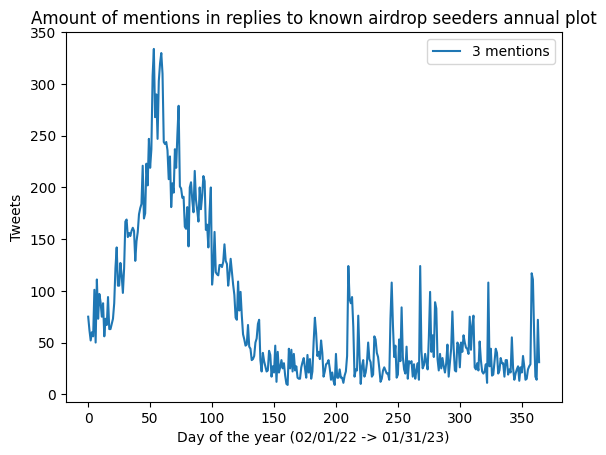

In [86]:
import json
import matplotlib.pyplot as plt
min_mens = 3
max_mens = 3

# create a dictionary to store the count of mentions of each length for each json file
mentions_count = {i: {j: 0 for j in range(min_mens, max_mens+1)} for i in range(365)}

# loop through each json file
for i in range(365):
    # read in the json file
    with open(f'replies_to_{i}.json', 'r') as f:
        json_file = json.load(f)
    
    # loop through each dictionary in the 'data' key
    counter = 0
    for data_dict in json_file['data']:
        
        # loop through each dictionary in the 'mentions' key and count the length of the list
        if 'entities' in data_dict and 'mentions' in data_dict['entities']:
            length = (len(data_dict['entities']['mentions']) - 1)
            if(length > max_mens or length < min_mens):
                continue
            #print(f"i: {i}")
            #print(f"length: {length}")
            mentions_count[i][length] += 1
            counter += 1
        if counter >= 1000:
            break


# create a longitudinal line plot
for j in range(min_mens,max_mens+1):
    x = [i for i in range(365)]
    y = [mentions_count[i][j] for i in range(365)]
    label = f"{j} mentions"
    plt.plot(x, y, label=label)

# set the title and labels for the plot
plt.title("Amount of mentions in replies to known airdrop seeders annual plot")
plt.xlabel("Day of the year (02/01/22 -> 01/31/23)")
plt.ylabel("Tweets")
plt.legend()

# display the plot
plt.show()

In [76]:
import json
import numpy as np

# Create a list to store the length of mentions in each JSON file
mentions_lengths = []

# Loop through all JSON files
for i in range(365):
    with open(f"replies_to_{i}.json", "r") as f:
        data = json.load(f)
    for item in data['data']:
        if 'entities' in item and 'mentions' in item['entities']:
            if len(item['entities']['mentions']) > 1:
                mentions_length = len(item['entities']['mentions'])
                mentions_lengths.append(mentions_length)

# Calculate mean and median of mentions_lengths

mean_mentions = np.mean(mentions_lengths)
std_dv_mentions = np.std(mentions_lengths)
print("Mean mentions length:", mean_mentions)
print("Std dv:", std_dv_mentions)

Median mentions length: 3.265069607928619
Std dv: 1.7953807425133095


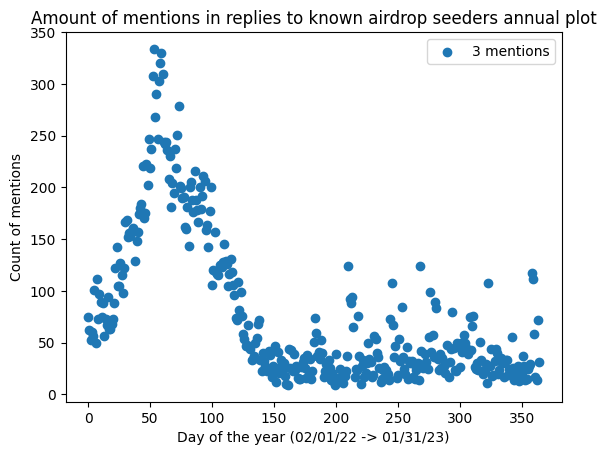

In [83]:
import matplotlib.pyplot as plt

min_mens = 3
max_mens = 3

# create a dictionary to store the count of mentions of each length for each json file
mentions_count = {i: {j: 0 for j in range(min_mens, max_mens+1)} for i in range(365)}

# loop through each json file
for i in range(365):
    # read in the json file
    with open(f'replies_to_{i}.json', 'r') as f:
        json_file = json.load(f)
    
    # loop through each dictionary in the 'data' key
    for data_dict in json_file['data']:
        
        # loop through each dictionary in the 'mentions' key and count the length of the list
        if 'entities' in data_dict and 'mentions' in data_dict['entities']:
            length = (len(data_dict['entities']['mentions']) - 1)
            if(length > max_mens or length < min_mens):
                continue
            mentions_count[i][length] += 1

# create a scatter plot
for j in range(min_mens, max_mens+1):
    x = [i for i in range(365)]
    y = [mentions_count[i][j] for i in range(365)]
    label = f"{j} mentions"
    plt.scatter(x, y, label=label)

# set the title and labels for the plot
plt.title("Amount of mentions in replies to known airdrop seeders annual plot")
plt.xlabel("Day of the year (02/01/22 -> 01/31/23)")
plt.ylabel("Count of mentions")
plt.legend()

# display the plot
plt.show()


/var/folders/x0/vvtsm8cj7pj6c58r0vbrtnmw0000gn/T/ipykernel_16071/124864719.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df['mean'] = df.mean(axis=1)


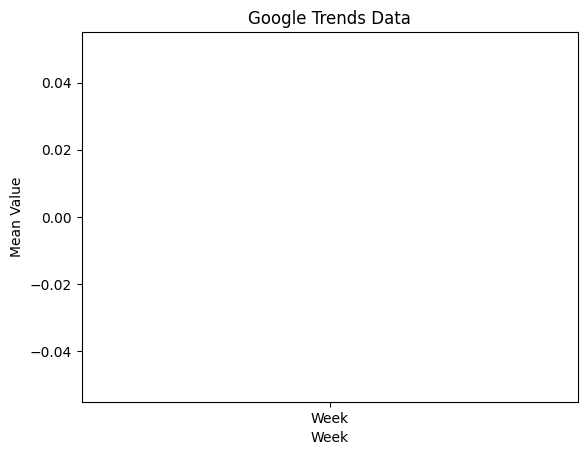

In [84]:
import pandas as pd
import matplotlib.pyplot as plt

# read in the csv file
df = pd.read_csv('cryptoAirdropTrends.csv')

# calculate the mean value for each week
df['mean'] = df.mean(axis=1)

# create a scatter plot
plt.scatter(df.index, df['mean'], s=10)

# set the title and labels for the plot
plt.title('Google Trends Data')
plt.xlabel('Week')
plt.ylabel('Mean Value')

# display the plot
plt.show()
